In [1]:
# https://www.kaggle.com/ajayrana/hymenoptera-data 에서 다운로드

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
# 2. 딥러닝 모델 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
     DEVICE=torch.device('cuda')
else:
     DEVICE=torch.device('cpu')

print('Using Pytorch version:',torch.__version__,'Device:',DEVICE)

Using Pytorch version: 1.11.0 Device: cuda


In [4]:
BATCH_SIZE = 16
EPOCHS = 10

In [5]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],)
    ]),
    'val' : transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],)
    ]),    
}

image_datasets = {x: datasets.ImageFolder("../data/hymenoptera_data",
                                         data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE,
                                            num_workers = 0,
                                            shuffle = True)for x in ['train', 'val']}



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train: torch.Size([16, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([16]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


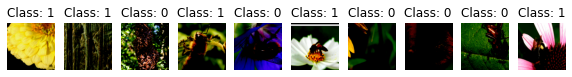

In [6]:
# 4. 데이터 확인하기(1)
for(X_train,Y_train)in dataloaders['train']:
    print('X_train:',X_train.size(),'type:', X_train.type())
    print('Y_train:',Y_train.size(),'type:', Y_train.type())
    break
# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)     # 여러 그래프 그리기, 첫숫자 : 행, 둘째 : 열
    plt.axis('off')           # 축없음
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class: ' + str(Y_train[i].item()))

In [7]:
#8. MLP모델 학습을 진행하며 "학습 데이터"에 대한 모델 성능을 확인하는 함수 정의(train_loader)
def train(model, train_loader, optimizer, log_interval):
    model.train()         # 학습상태로 지정
    for batch_idx,(image, label) in enumerate(train_loader):
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        optimizer.zero_grad()
        output=model(image)
        loss=criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval==0:
            print("Train Epoch: {}[{}/{}({:.0f}%)]\tTrain Loss: {:.6f}"
                  .format(Epoch,batch_idx * len(image),
                len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))

In [8]:
#9. 학습되는 과정속에서 "검증데이터"에 대한 모델 성능을 확인하는 함수 정의(test_loader)
def evaluate(model,test_loader):
    model.eval()                  # 평가상태로 지정
    test_loss=0
    correct=0
    
    with torch.no_grad():
        for image, label in test_loader:
            image=image.to(DEVICE)              # 8과 동일
            label=label.to(DEVICE)              # 8과 동일
            output=model(image)                 # 8과 동일
            test_loss+=criterion(output,label).item()
            prediction = output.max(1,keepdim = True)[1]
            # MLP 모델의 output값은 크기가 10인 벡터값입니다. 
            # 계산된 벡터값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단합니다.
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            # MLP모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수를 저장
                        
    test_loss /= len(test_loader.dataset)
    # 현재까지 계산된 test_loss 값을 test_loader내에 존재하는 Mini-Batch 개수(=10)만큼 나눠 평균 Loss값으로 계산.
    test_accuracy=100.*correct / len(test_loader.dataset)
    # test_loader 데이터중 얼마나 맞췄는지를 계산해 정확도를 계산합니다.
    return test_loss, test_accuracy

In [9]:
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [10]:
# optimizer, objective Function 설정하기
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(DEVICE)     # 비용 함수에 소프트맥스 함수 포함되어져 있음.



In [ ]:
#10. MLP학습을 실행하면서 Train, Test set의 Loss및 Test set Accuracy를 확인하기
for Epoch in range(1,EPOCHS+1):
    train(model,dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch,test_loss,test_accuracy))

Train Epoch: 1[0/397(0%)]	Train Loss: 0.729194
Train Epoch: 1[80/397(20%)]	Train Loss: 0.608217
Train Epoch: 1[160/397(40%)]	Train Loss: 0.711506
Train Epoch: 1[240/397(60%)]	Train Loss: 0.614756
Train Epoch: 1[320/397(80%)]	Train Loss: 0.718195

[EPOCH: 1], 	Test Loss: 0.0431, 	Test Accuracy: 56.42 %

Train Epoch: 2[0/397(0%)]	Train Loss: 0.678773
Train Epoch: 2[80/397(20%)]	Train Loss: 0.640187
Train Epoch: 2[160/397(40%)]	Train Loss: 0.636199
Train Epoch: 2[240/397(60%)]	Train Loss: 0.939772
Train Epoch: 2[320/397(80%)]	Train Loss: 0.698637

[EPOCH: 2], 	Test Loss: 0.0427, 	Test Accuracy: 61.96 %

Train Epoch: 3[0/397(0%)]	Train Loss: 0.721680
Train Epoch: 3[80/397(20%)]	Train Loss: 0.620613
Train Epoch: 3[160/397(40%)]	Train Loss: 0.600165
Train Epoch: 3[240/397(60%)]	Train Loss: 0.784950
Train Epoch: 3[320/397(80%)]	Train Loss: 0.709233

[EPOCH: 3], 	Test Loss: 0.0411, 	Test Accuracy: 63.73 %

Train Epoch: 4[0/397(0%)]	Train Loss: 0.633277
Train Epoch: 4[80/397(20%)]	Train Loss: 0

In [ ]:
# 11. Imagenet데이터로 미리 학습된 ResNet18 모델을 불러온 후 
# 개미, 벌 이미지 데이터에 맞게 Fine-tuning 해보기

model = models.resnot18(presented = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
EPOCHS = 10
for epoch in range(1,EPOCHS + 1):
    train(model,dataloaders[\"train\"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders[\"val\"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch,valid_loss, valid_accuracy))



